In [1]:
import os, glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.io
import cartopy.io.img_tiles
import cartopy.feature
import shapely
import shapely.ops
import pyproj

import functions

## Define Variables

In [2]:
skip_ncgen_prcp = True # set 'False' for the first run to save temporary processed netcdf files

bounds = [88.6875, 25.5, 93.375, 28.625] # covers the basin over Bhutan
bounds_bhutan = [88.6875, 26.6875, 92.125, 28.25] # covers Bhutan
date_range = ['1996-01-01','2019-12-31'] # for statistics

path_data = '/rcfs/projects/sage/hydro-modeling/datasets'
#path_data = 'datasets' # if there is a symlink created for the absolute path above
list_models = ['ERA5', 'ERA5-L', 'MSWX-P', 'GSWP3-W5E5', 'HMA', 'GMFD'] # a list of model variables
years_load = np.arange(1996, 2020) # for loading datasets
path_temps, path_figs = 'tempfiles', 'figures'
os.makedirs(path_temps, exist_ok = True)
os.makedirs(path_figs, exist_ok = True)

vars_list = {
    'ERA5': [
        't2m', # 2 metre temperature
        'tp', # Total precipitation
    ],
    'ERA5-L': [
        't2m', # 2 metre temperature
        'tp', # Total precipitation
    ],
    'MSWX-P': [
        'air_temperature',
        'air_temperature_max',
        'air_temperature_min',
        'precipitation',
    ],
    'GSWP3-W5E5': [
        'pr', # Precipitation
        'tas', # Near-Surface Air Temperature
        'tasmax', # Near-Surface Air Temperature
        'tasmin', # Near-Surface Air Temperature
    ],
    'HMA': [
        'P_CHP', # Downscaled CHIRPS total precipitation
        'P_ECMWF', # Downscaled ECMWF total precipitation
        'Tair', # Downscaled ECMWF near-surface temperature
    ],
    'GMFD': [
        'prcp', # Precipitation
        'tas', # Air temperature
        'tmax', # Maximum air temperature
        'tmin', # Minimum air temperature
    ],
}
key_prcp = {'ERA5': ['tp'], 'ERA5-L': ['tp'], 'MSWX-P': ['precipitation'], 'GSWP3-W5E5': ['pr'], 'HMA': ['P_CHP', 'P_ECMWF'], 'GMFD': ['prcp']} # preipitation variables in each model

## Load Datasets

In [3]:
list_ds = []
if not skip_ncgen_prcp:
    for m in list_models:
        ds = functions.read_datasets(path = path_data, model = m, years = years_load, bounds = bounds, vars_list = vars_list[m], save_nc = None) # load datasets to process
        for key in key_prcp[m]: ds[key] = functions.convert_precipitation(da_prcp = ds[key], model = m) # convert a pricipitation variable into total precipitation per step
        list_ds.append(ds)

In [4]:
list_name_prcp, list_da_mprcp, list_da_awetday = [], [], []
if not skip_ncgen_prcp:
    for i, m in enumerate(list_models):
        for key in key_prcp[m]:
            list_name_prcp.append(f'{functions.models_name[m]}: "{key}"')

            # Figure 10: Mean Monthly Precipitation Total
            da = list_ds[i][key].resample(time = '1MS', skipna = False).sum() # Monthly Precipitation Total
            date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da['time'][0].values))
            date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da['time'][-1].values))
            da_mprcp = da.sel(time = pd.date_range(date_min, date_max, freq = '1MS')).groupby('time.month').mean() # Mean by month
            da_mprcp.to_netcdf(os.path.join(path_temps, f'_ncgen_Fig10_prcp_{m}_{key}.nc'))
            list_da_mprcp.append(da_mprcp)

            # Figure 11: Mean Annual Wet Days (> 1 mm/day)
            da = list_ds[i][key].resample(time = '1D', skipna = False).sum() # Daily Precipitation Total
            date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da['time'][0].values))
            date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da['time'][-1].values))
            da_awetday = da.sel(time = pd.date_range(date_min, date_max, freq = '1D')).compute()
            da_awetday = np.isfinite(da_awetday.where(da_awetday > 1)).resample(time = '1YS').sum().mean(dim = 'time') # count annual wet days over 1 mm and average
            da_awetday.to_netcdf(os.path.join(path_temps, f'_ncgen_Fig11_wetday_{m}_{key}.nc'))
            list_da_awetday.append(da_awetday)
else:
    for i, m in enumerate(list_models):
        for key in key_prcp[m]:
            list_name_prcp.append(f'{functions.models_name[m]}: "{key}"')
            list_da_mprcp.append(xr.load_dataarray(os.path.join(path_temps, f'_ncgen_Fig10_prcp_{m}_{key}.nc'), decode_coords = 'all'))
            list_da_awetday.append(xr.load_dataarray(os.path.join(path_temps, f'_ncgen_Fig11_wetday_{m}_{key}.nc'), decode_coords = 'all'))


## Load Datasets (BhutanClim)

In [5]:
var_BhutanClim = 'pr'
path_BhutanClim = glob.glob(f'/rcfs/projects/sage/hydro-modeling/datasets/BhutanClim/{var_BhutanClim}_*.nc')[0]
da_BhutanClim = xr.open_dataset(path_BhutanClim)[var_BhutanClim]
# Figure 10: Mean Monthly Precipitation Total
da_BhutanClim_mprcp = da_BhutanClim.resample(time = '1MS', skipna = False).sum() # Monthly Precipitation Total
date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da_BhutanClim_mprcp['time'][0].values))
date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da_BhutanClim_mprcp['time'][-1].values))
da_BhutanClim_mprcp = da_BhutanClim_mprcp.sel(time = pd.date_range(date_min, date_max, freq = '1MS')).groupby('time.month').mean() # Mean by month
list_name_prcp.append(f'BhutanClim: "{var_BhutanClim}"')
list_da_mprcp.append(da_BhutanClim_mprcp)

# Figure 11: Mean Annual Wet Days (> 1 mm/day)
da_BhutanClim_awetday = da_BhutanClim.resample(time = '1D', skipna = False).sum() # Daily Precipitation Total
date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da_BhutanClim_awetday['time'][0].values))
date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da_BhutanClim_awetday['time'][-1].values))
da_BhutanClim_awetday = da_BhutanClim_awetday.sel(time = pd.date_range(date_min, date_max, freq = '1D')).compute()
da_BhutanClim_awetday = np.isfinite(da_BhutanClim_awetday.where(da_BhutanClim_awetday > 1)).resample(time = '1YS').sum().mean(dim = 'time') # count annual wet days over 1 mm and average
list_da_awetday.append(da_BhutanClim_awetday)

## Set Plot Properties

In [6]:
shp_file = os.path.join('shapefiles', 'btn_admbnda_adm1_bnlc_20201026.shp') # Bhutan Administrative Boundaries (Level 1)
shp_file_mask = os.path.join('shapefiles', 'gridmask_bhutan.shp') # Polygon masking outside of Bhutan

baseMap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite')

shape_feature = cartopy.feature.ShapelyFeature(cartopy.io.shapereader.Reader(shp_file).geometries(), crs = cartopy.crs.PlateCarree(), facecolor = 'none', linewidth = 0.5) # Bhutan Administrative Boundaries (Level 1)
shape_feature_mask = cartopy.feature.ShapelyFeature(cartopy.io.shapereader.Reader(shp_file_mask).geometries(), crs = cartopy.crs.PlateCarree(), facecolor = 'w', linewidth = 0.5) # masking outside of Bhutan
polygon_feature = shapely.unary_union(shapely.geometry.MultiPolygon(shape_feature.geometries())) # applying statistics only for Bhutan

# function to create a masked dataarray for statistics
def create_da_masked(da, polygon = None):
    if polygon is None: return da
    if 'lon' in da.dims and 'lat' in da.dims: x, y = 'lon', 'lat'
    elif 'longitude' in da.dims and 'latitude' in da.dims: x, y = 'longitude', 'latitude'
    elif 'x' in da.dims and 'y' in da.dims: x, y = 'x', 'y'
    else: return da
    xs, ys = np.meshgrid(da[x], da[y])
    xys = np.stack([xs.flatten(), ys.flatten()], axis = -1)
    mask = shapely.contains_xy(polygon, xys)
    mask = mask.reshape([len(da[y]), len(da[x])])
    return da.where(mask == True)

# function to plot a geospatial map of variable
def plot_models(list_da, list_name, list_transform, list_shapes, bounds, norm = None, cmap = 'nipy_spectral', suptitle = '', clabel = '', stats = False, stats_polygon = None, stats_unit = 'mm', savefig = None, show = True):
    nplot = len(list_da)
    fig, axes = plt.subplots(nrows = (1 + nplot) // 2, ncols = 2, figsize = (10, 14), subplot_kw = {'projection': baseMap.crs})
    fig.suptitle(suptitle)
    for i, ax in enumerate(axes.flat):
        ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])
        fgl = ax.gridlines(crs = cartopy.crs.PlateCarree(), linestyle = '--', alpha = 0.25, draw_labels = True)
        fgl.top_labels, fgl.right_labels = False, False
        fgl.xlabel_style, fgl.ylabel_style = {'color': 'gray', 'size': 8}, {'color': 'gray', 'size': 8}

        if i < nplot:
            fda = list_da[i].plot(ax = ax, transform = list_transform[i], norm = norm, cmap = cmap, add_colorbar = False)
            
            if stats == True or stats_polygon is not None: # applying statistics only for Bhutan
                if list_transform[i] == cartopy.crs.PlateCarree(): da_masked = create_da_masked(da = list_da[i], polygon = stats_polygon)
                else:
                    transformer = pyproj.Transformer.from_crs(cartopy.crs.PlateCarree(), list_transform[i])
                    da_masked = create_da_masked(da = list_da[i], polygon = shapely.ops.transform(transformer.transform, polygon_feature))
                stats = 'Mean: {:.0f} {}, Min: {:.0f} {}, Max: {:.0f} {}'.format(np.nanmean(da_masked), stats_unit, np.nanmin(da_masked), stats_unit, np.nanmax(da_masked), stats_unit)
                ax.set_title(list_name[i] + '\n' + stats)
            else: ax.set_title(list_name[i])
        else: ax.add_image(baseMap, 10)
        for s in list_shapes: ax.add_feature(s)
        
    fig.subplots_adjust(bottom = 0.05)
    cax = fig.add_axes([0.2, 0.025, 0.6, 0.02])
    fig.colorbar(fda, label = clabel, cax = cax, orientation = 'horizontal')
    fig.tight_layout(rect = [0, 0.05, 1, 1])

    if savefig is not None: plt.savefig(savefig, bbox_inches = 'tight')
    if show is not None: plt.show()
    return

# colormaps
precip_11lev = np.array([
    [255, 255, 255],
    [237, 250, 194],
    [205, 255, 205],
    [153, 240, 178],
    [83, 189, 159],
    [50, 166, 150],
    [50, 150, 180],
    [5, 112, 176],
    [5, 80, 140],
    [10, 31, 150],
    [44, 2, 70],
    [106, 44, 90],
])
precip_11lev = precip_11lev / 255

prcp_bounds = [0, 1, 2, 5, 10, 20, 200, 300, 500, 1000]
prcp_norm = matplotlib.colors.BoundaryNorm(boundaries = prcp_bounds, ncolors = 13, extend = 'max')

prcp_bounds_wetday = np.linspace(90, 170, 5, endpoint = True)
prcp_norm_wetday = matplotlib.colors.BoundaryNorm(boundaries = prcp_bounds_wetday, ncolors = 12, extend = 'both')

## Figure 10a: Mean Monthly Precipitation Total: January

/tmp/ipykernel_5761/712435034.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


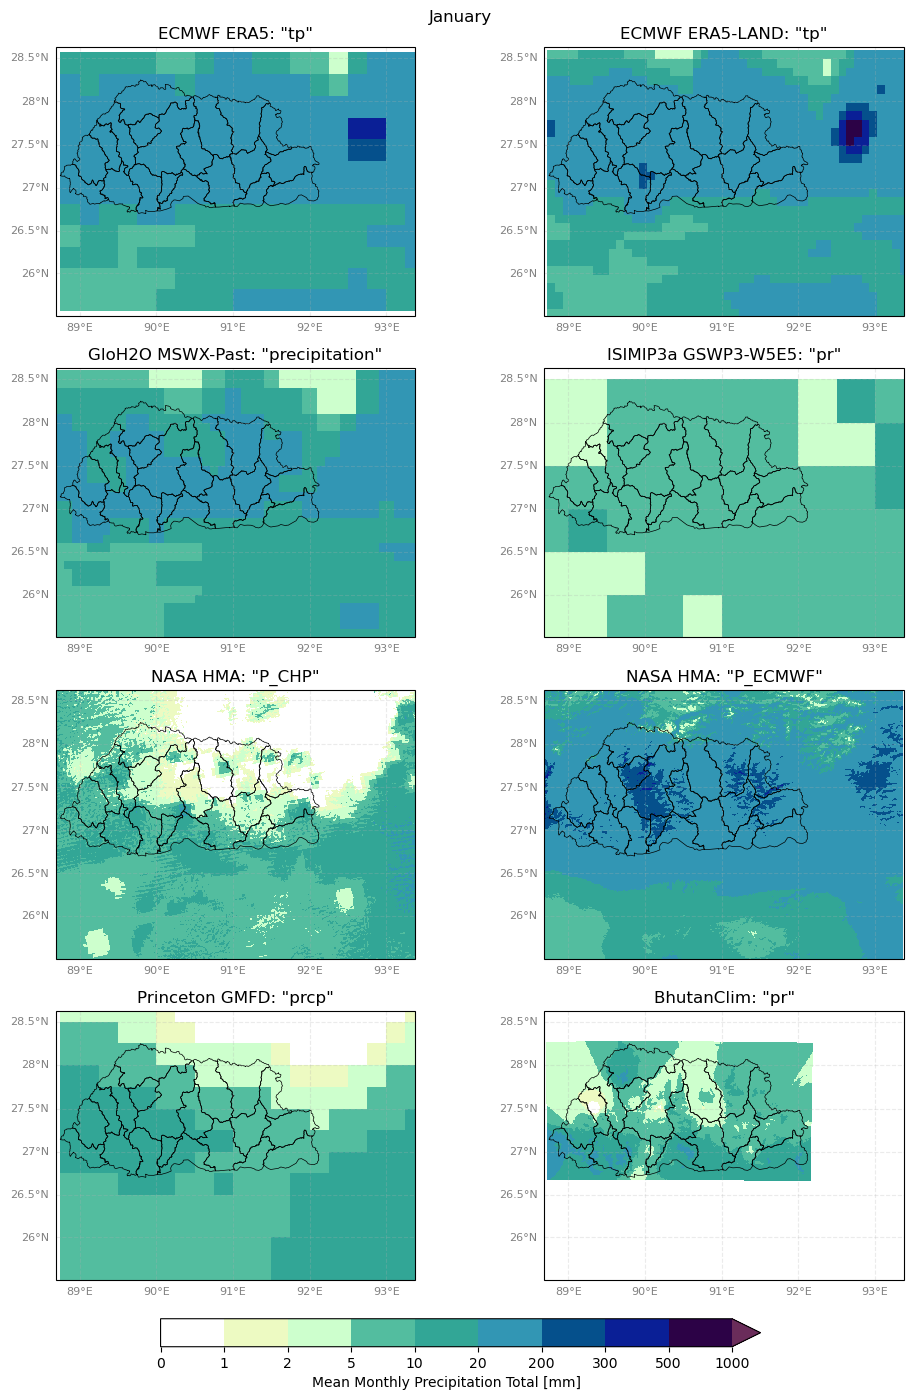

In [7]:
# Figure 10a: Mean Monthly Precipitation Total: January (Basin)
month = 1
plot_models(list_da = [da.sel(month = month) for da in list_da_mprcp], list_name = list_name_prcp,
            list_transform = [cartopy.crs.PlateCarree()] * (len(list_da_mprcp) - 1) + [cartopy.crs.epsg(5266)],
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm, cmap = matplotlib.colors.ListedColormap(precip_11lev), suptitle = 'January', clabel = 'Mean Monthly Precipitation Total [mm]',
            stats = False, stats_polygon = None, stats_unit = 'mm',
            savefig = os.path.join(path_figs, 'Lehner-Fig10-Jan-Basin_wBhutanClim.png'), show = True)

/tmp/ipykernel_5761/712435034.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


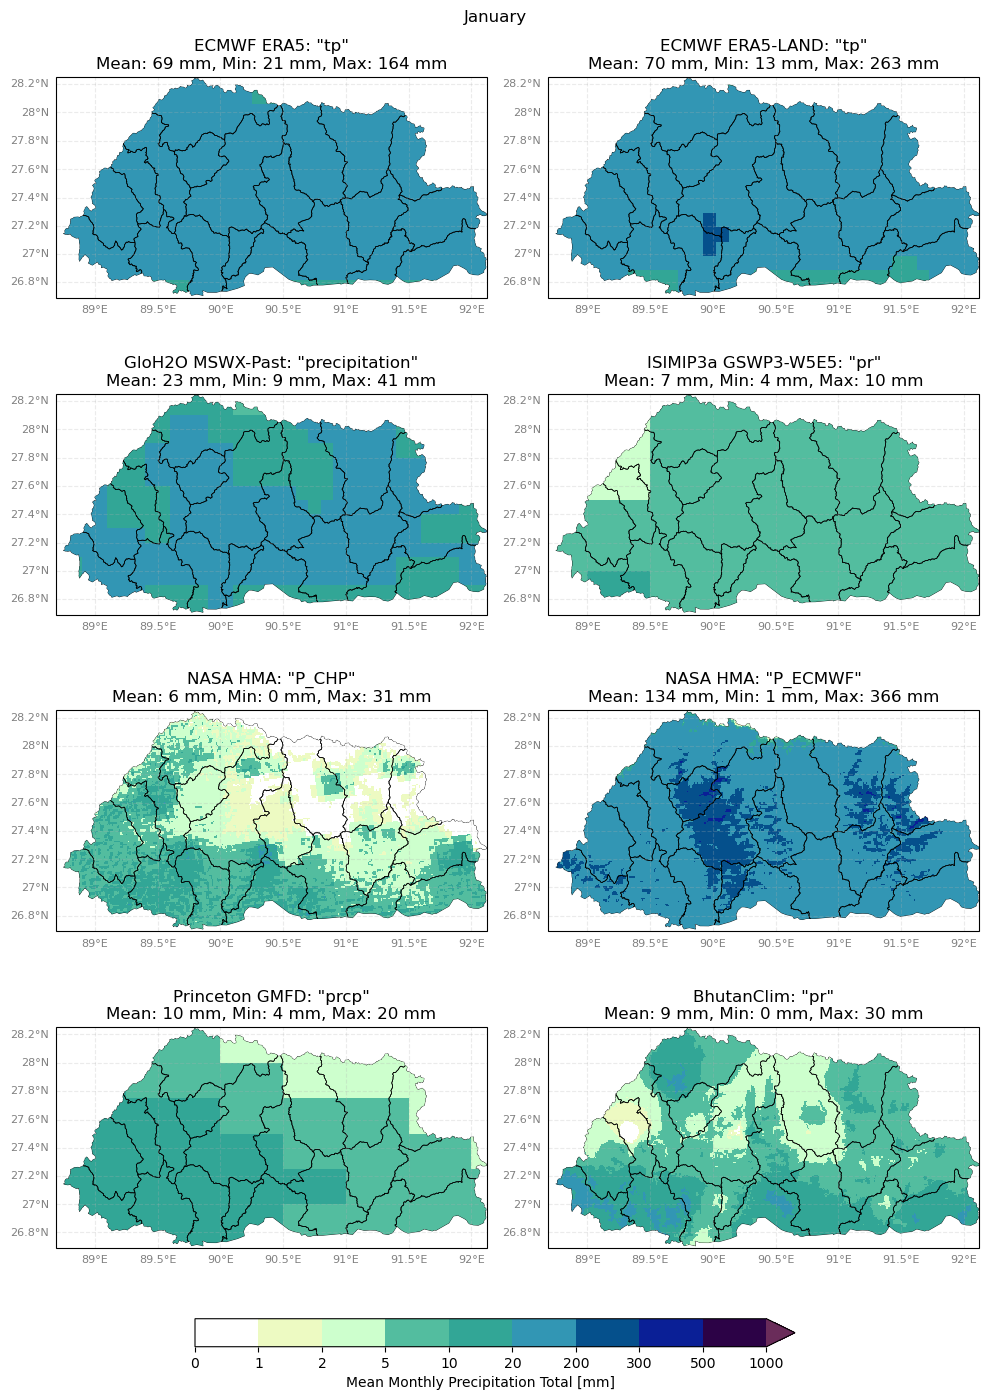

In [8]:
# Figure 10a: Mean Monthly Precipitation Total: January (Bhutan) w/ statistics
month = 1
plot_models(list_da = [da.sel(month = month) for da in list_da_mprcp], list_name = list_name_prcp,
            list_transform = [cartopy.crs.PlateCarree()] * (len(list_da_mprcp) - 1) + [cartopy.crs.epsg(5266)],
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm, cmap = matplotlib.colors.ListedColormap(precip_11lev), suptitle = 'January', clabel = 'Mean Monthly Precipitation Total [mm]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'mm',
            savefig = os.path.join(path_figs, 'Lehner-Fig10-Jan-Bhutan_wBhutanClim.png'), show = True)

## Figure 10b: Mean Monthly Precipitation Total: July

/tmp/ipykernel_5761/712435034.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


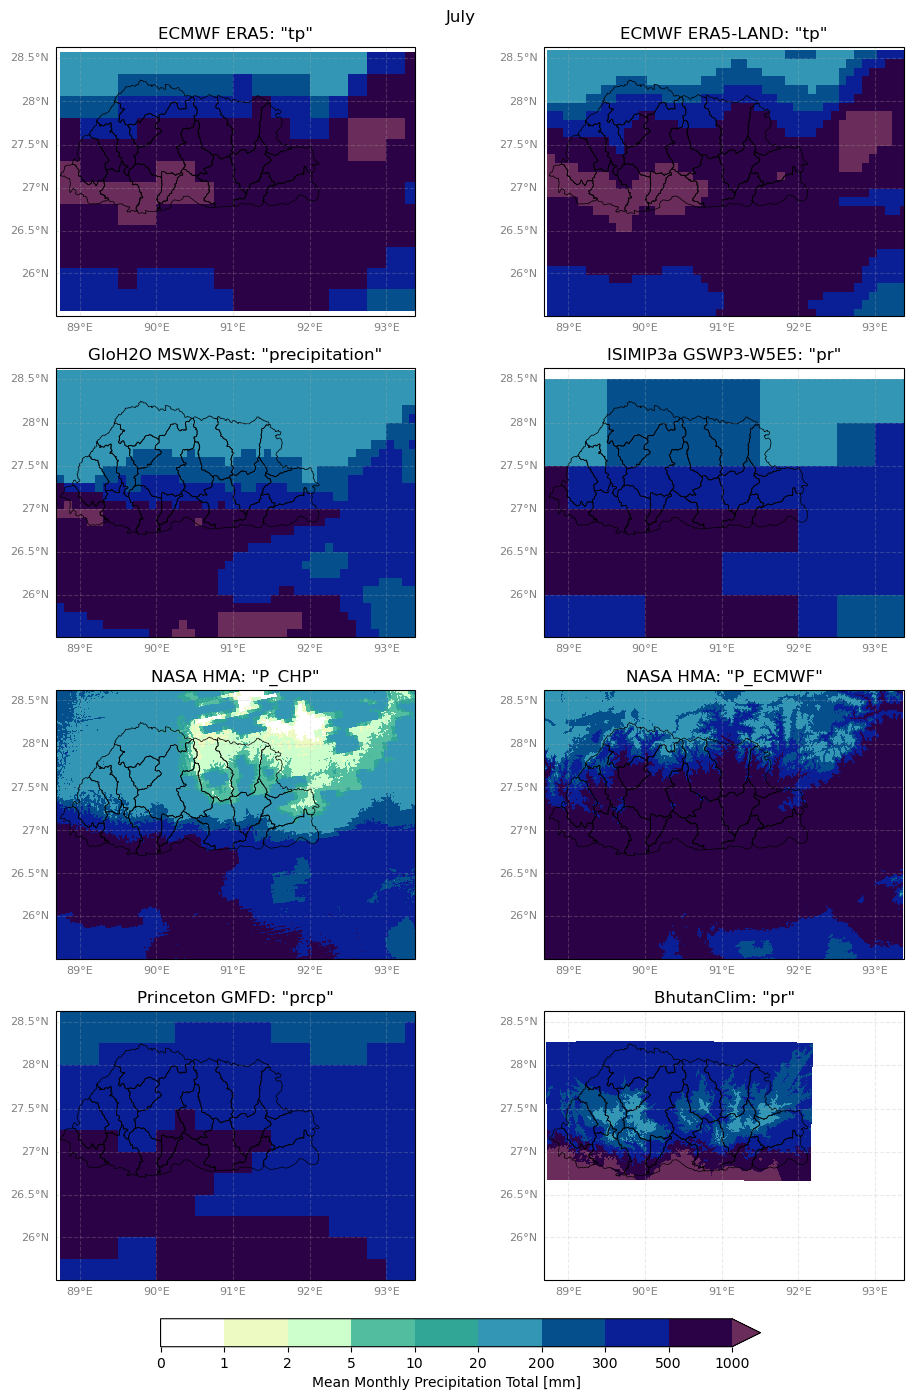

In [9]:
# Figure 10b: Mean Monthly Precipitation Total: July (Basin)
month = 7
plot_models(list_da = [da.sel(month = month) for da in list_da_mprcp], list_name = list_name_prcp,
            list_transform = [cartopy.crs.PlateCarree()] * (len(list_da_mprcp) - 1) + [cartopy.crs.epsg(5266)],
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm, cmap = matplotlib.colors.ListedColormap(precip_11lev), suptitle = 'July', clabel = 'Mean Monthly Precipitation Total [mm]',
            stats = False, stats_polygon = None, stats_unit = 'mm',
            savefig = os.path.join(path_figs, 'Lehner-Fig10-July-Basin_wBhutanClim.png'), show = True)

/tmp/ipykernel_5761/712435034.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


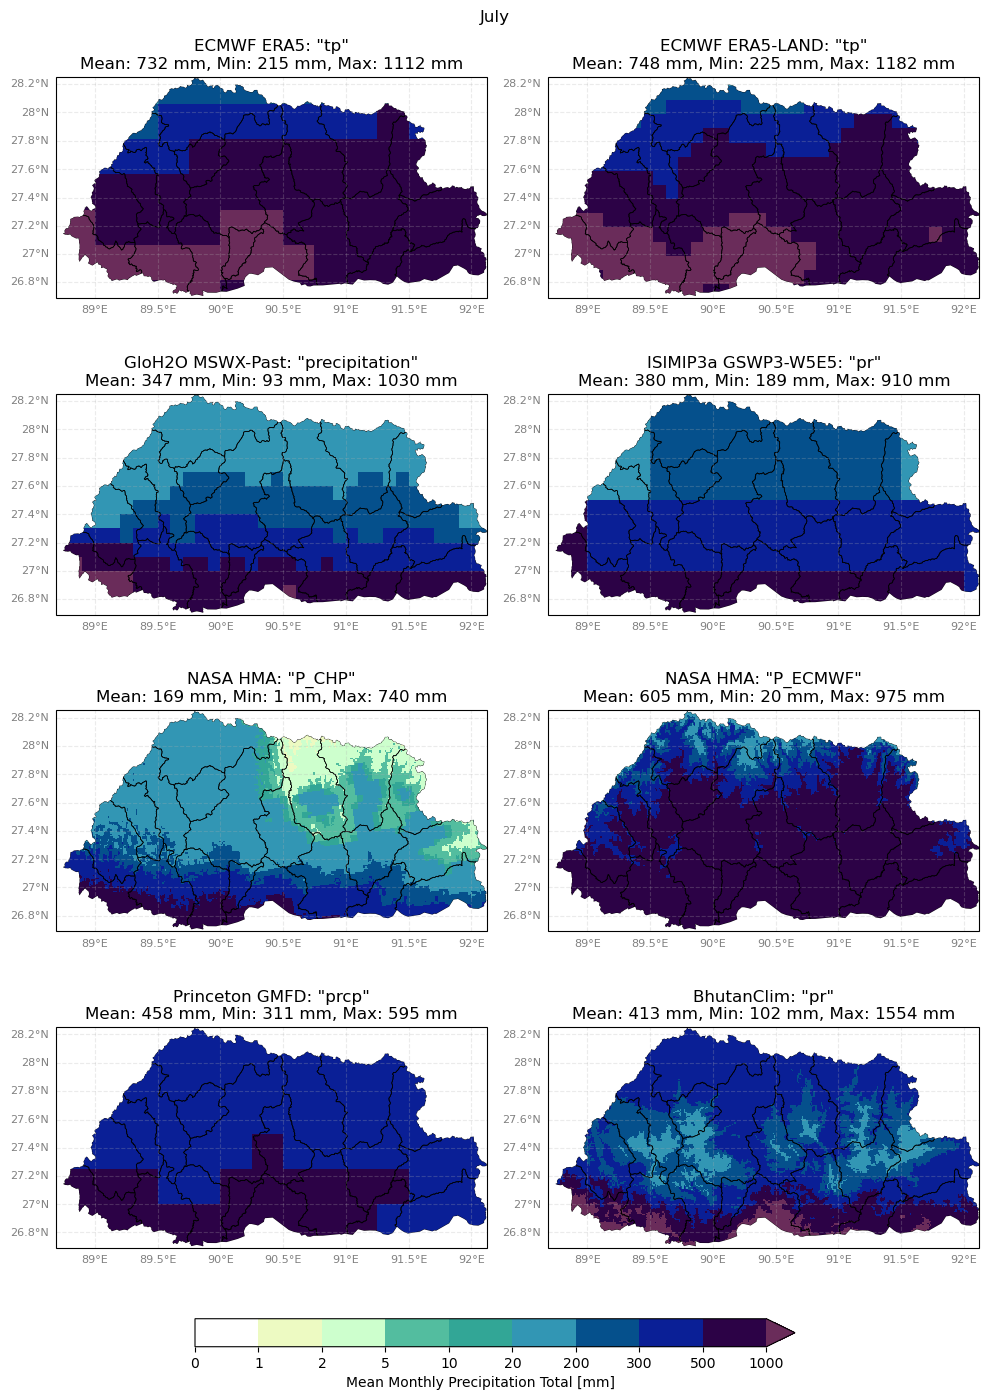

In [10]:
# Figure 10b: Mean Monthly Precipitation Total: July (Bhutan) w/ statistics
month = 7
plot_models(list_da = [da.sel(month = month) for da in list_da_mprcp], list_name = list_name_prcp,
            list_transform = [cartopy.crs.PlateCarree()] * (len(list_da_mprcp) - 1) + [cartopy.crs.epsg(5266)],
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm, cmap = matplotlib.colors.ListedColormap(precip_11lev), suptitle = 'July', clabel = 'Mean Monthly Precipitation Total [mm]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'mm',
            savefig = os.path.join(path_figs, 'Lehner-Fig10-July-Bhutan_wBhutanClim.png'), show = True)

## Figure 11: Mean Annual Wet Days

/tmp/ipykernel_5761/712435034.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


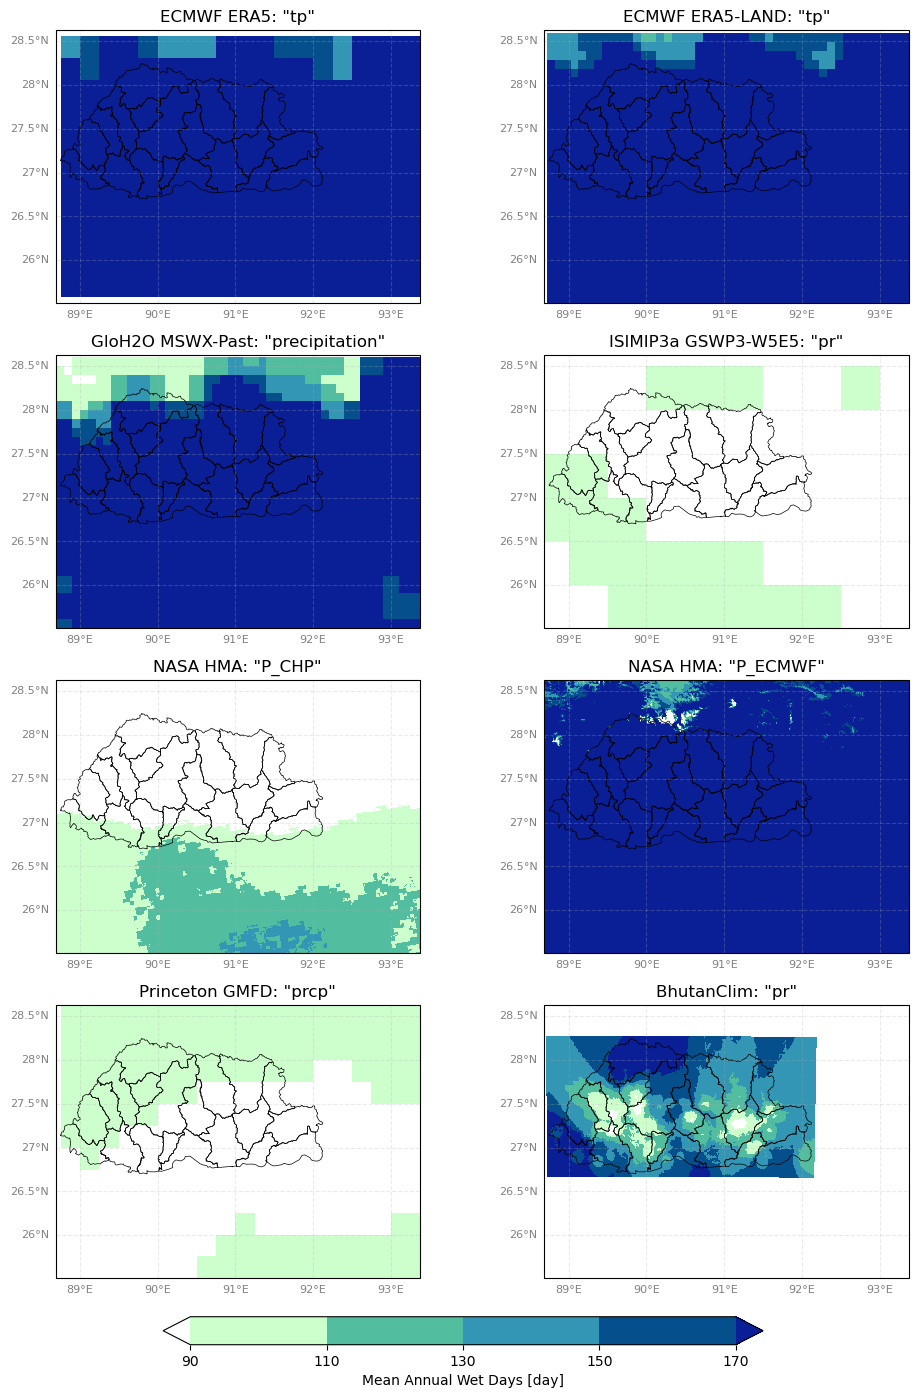

In [11]:
# Figure 11: Mean Annual Wet Days (> 1 mm/day, Basin)
plot_models(list_da = list_da_awetday, list_name = list_name_prcp,
            list_transform = [cartopy.crs.PlateCarree()] * (len(list_da_awetday) - 1) + [cartopy.crs.epsg(5266)],
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_wetday, cmap = matplotlib.colors.ListedColormap(precip_11lev[:-2]), suptitle = '', clabel = 'Mean Annual Wet Days [day]',
            stats = False, stats_polygon = None, stats_unit = 'days',
            savefig = os.path.join(path_figs, 'Lehner-Fig11-Basin_wBhutanClim.png'), show = True)

/tmp/ipykernel_5761/712435034.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


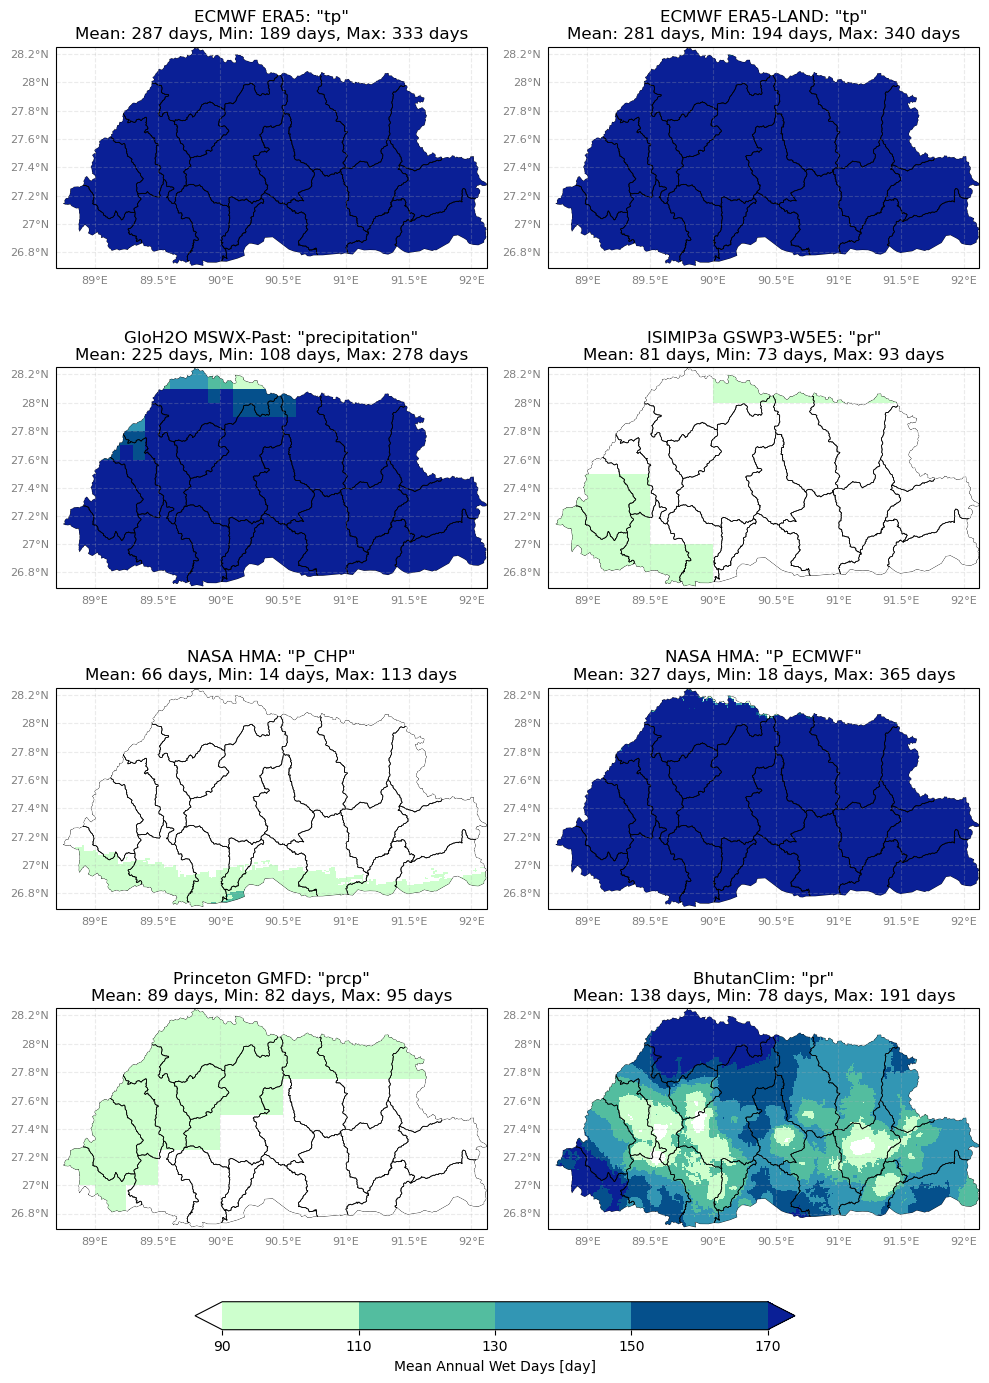

In [12]:
# Figure 11: Mean Annual Wet Days (> 1 mm/day, Bhutan) w/ statistics
plot_models(list_da = list_da_awetday, list_name = list_name_prcp,
            list_transform = [cartopy.crs.PlateCarree()] * (len(list_da_awetday) - 1) + [cartopy.crs.epsg(5266)],
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_wetday, cmap = matplotlib.colors.ListedColormap(precip_11lev[:-2]), suptitle = '', clabel = 'Mean Annual Wet Days [day]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'days',
            savefig = os.path.join(path_figs, 'Lehner-Fig11-Bhutan_wBhutanClim.png'), show = True)